<a href="https://colab.research.google.com/github/dakilaledesma/272-iNat-Final/blob/main/272_iNat_Final_Project_(TF_GPU_Impatiens_glandulifera).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import requests
import os
from tqdm import tqdm
from joblib import Parallel, delayed

classif_dict = {77490: "Impatiens balfourii", 47892: "Impatiens glandulifera"}
ims_dict = {}

for id, sp in classif_dict.items():
  o_url = f"https://api.inaturalist.org/v1/observations?quality_grade=research&identifications=any&place_id=any&taxon_id={id}&verifiable=true&per_page=200"
  r = requests.get(o_url)
  obs = r.text
  obs = json.loads(obs)
  total_results = obs["total_results"]

  if total_results < 200:
      pages = 1
  elif total_results % 200 != 0:
      pages = total_results // 200 + 1
  else:
      pages = total_results / 200

  ims = []
  for page in range(1, pages + 1):
      url = f'{o_url}{page}'
      r = requests.get(url)
      obs = r.text
      obs = json.loads(obs)

      for r in obs['results']:
          for im in r["photos"]:
              ims.append(im["url"].replace("square", "large"))

  ims_dict[sp] = ims

  try:
    os.makedirs(f"data/{sp}")
  except FileExistsError:
    pass

min_ims = min([len(a) for a in ims_dict.values()])
for sp, ims in ims_dict.items():
  def down_ims(idx, im):
    if idx >= min_ims:
      return

    response = requests.get(im)
    file = open(f"data/{sp}/{idx}.jpg", "wb")
    file.write(response.content)
    file.close()

  Parallel(n_jobs=os.cpu_count())(delayed(down_ims)(idx, im) for idx, im in tqdm(enumerate(ims), total=min_ims))  

2268



100%|██████████| 2268/2268 [03:45<00:00, 10.07it/s]

100%|██████████| 35328/35328 [04:23<00:00, 134.09it/s]  


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import numpy as np
import os
import PIL
import PIL.Image

image_r = 331
bs = 8
model = tf.keras.applications.nasnet.NASNetLarge(
    input_shape=(image_r, image_r, 3), weights='imagenet', include_top=False
)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(2048, activation='relu')(flat1)
class1 = Dense(512, activation='relu')(class1)
output = Dense(2, activation='softmax')(class1)

model = Model(inputs=model.inputs, outputs=output)

train_ds = tf.keras.utils.image_dataset_from_directory(
  "data/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_r, image_r),
  batch_size=bs,
  label_mode='categorical')

val_ds = tf.keras.utils.image_dataset_from_directory(
  "data/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_r, image_r),
  batch_size=bs,
  label_mode='categorical')

model.compile(
  optimizer='sgd',
  loss=tf.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)

mc = tf.keras.callbacks.ModelCheckpoint(
    "model_cp",
    monitor="val_acc",
    verbose=0,
    save_best_only=True,
    mode="auto",
    save_freq="epoch"
)

model.fit(
  train_ds, validation_data=val_ds, batch_size=bs,
  epochs=5,
  callbacks=[],
  shuffle=True
)

model.save("model")


343621632/343610240 [==============================] - 2s 0us/step
Found 4536 files belonging to 2 classes.
Using 3629 files for training.
Found 4536 files belonging to 2 classes.
Using 907 files for validation.
Epoch 1/5
454/454 [==============================] - 449s 904ms/step - loss: 0.1679 - accuracy: 0.9435 - val_loss: 2.0884 - val_accuracy: 0.5469
Epoch 2/5
454/454 [==============================] - 406s 893ms/step - loss: 0.0063 - accuracy: 0.9986 - val_loss: 0.9760 - val_accuracy: 0.7001
Epoch 3/5
454/454 [==============================] - 406s 894ms/step - loss: 9.8201e-04 - accuracy: 1.0000 - val_loss: 0.5177 - val_accuracy: 0.8412
Epoch 4/5
454/454 [==============================] - 406s 894ms/step - loss: 3.7834e-04 - accuracy: 1.0000 - val_loss: 0.1776 - val_accuracy: 0.9482
Epoch 5/5
454/454 [==============================] - 406s 893ms/step - loss: 3.6594e-04 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9824
INFO:tensorflow:Assets written to: model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
! pip install lime

     |████████████████████████████████| 275 kB 8.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=ad21c699a6fe3954a08dd0ab909a6e543c0844cde2edd8e368767d8d7d2bb0ec
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                             

  0%|          | 0/3000 [00:00<?, ?it/s]

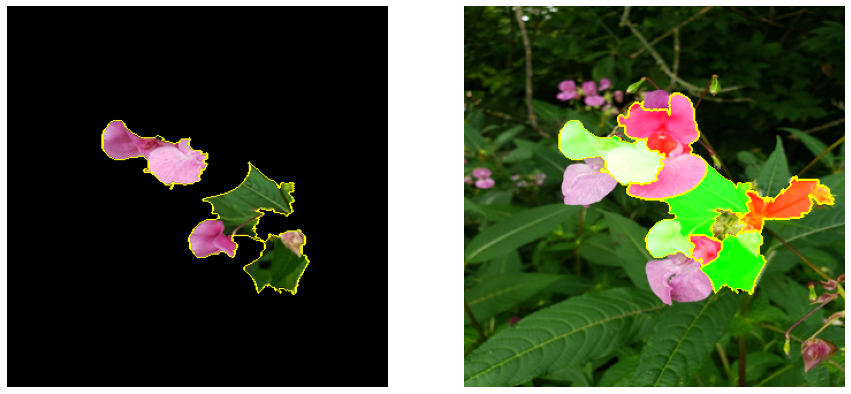

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

model = load_model("model")
print(model.summary())

im = Image.open("large.jpeg")
im = im.resize((331, 331))
im = np.array(im)
im = np.array([im])
im = im / 255

print(im.shape)
print(model.predict(im))

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(im[0].astype('double'), model.predict,
                                         top_labels=2, hide_color=0, num_samples=3000)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.show()